In [ ]:
!nvidia-smi

Tue Sep 28 11:34:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Initial Setup

## Mount and Import

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project'

/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project


In [ ]:
!ls

data_upload_v3	ishra_dataset  saved_models
DONE-FOR-FINAL	puran_files    Untitled


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
from torchvision.utils import make_grid


import glob, pickle
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import os, copy, time, pickle
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS

## Hyper Parameters

In [ ]:
# hyper params
epochs = 100
batch_size = 20
learning_rate = 0.001
momentum = 0.9

dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/data_upload_v3'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

## data_transforms

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224), # diff
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## data loaders

In [ ]:
dataset_path

'/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/data_upload_v3'

In [ ]:
data_dir = dataset_path

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size= batch_size,
                                              shuffle=True)
              for x in ['train', 'test']}

In [ ]:
print(len(dataloaders['train']))
print(len(dataloaders['test']))

121
155


In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  ## 0: covid, and 1: noncovid

In [ ]:
dataset_sizes

{'test': 3100, 'train': 2420}

In [ ]:
class_names

['covid', 'non']

## func - imshow

In [ ]:
def imshow(inp, title= None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.rcParams["figure.figsize"] = (20,3)

    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## func - log status


In [ ]:
def writeLog (filePath,txt) :
  # Open a file with access mode 'a'
  file_object = open(filePath, 'a')

  # Append 'hello' at the end of file
  file_object.write(txt + "\n")

  # Close the file
  file_object.close()

## func - visualize_model

In [ ]:
def visualize_model(model, num_images= 8): #num_images= 64
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)


            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} \n actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# func - train_model

In [ ]:
for inputs, labels in dataloaders['train']:
    print("label:", labels.data.numpy())
    print(len(labels))
    break

In [ ]:
len(labels)

20

In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_size, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    test_acc= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            cur_batch_ind = 0
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device) # images are here
                labels = labels.to(device) # actual label are here
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # get predicted label
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() 
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/len(labels)
                cur_batch_ind +=1

                print()
                print('{} \t Epoch: {} \t Batch: {} \t Acc: {:.4f}'.format(phase, epoch+1, cur_batch_ind, cur_acc))
                print("preds:", preds.cpu().numpy())
                print("label:", labels.cpu().data.numpy())



                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    test_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            txt = '{} \t Epoch: {} \t Epoch Loss: {:.4f} \t Epoch Acc: {:.4f}'.format(phase, epoch+1, epoch_loss, epoch_acc)
            print(txt + '\n\n')

            
            if phase == 'train' :
                # write on train log
                writeLog ('/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/train_log_densenet121.txt', txt)
                
            elif phase == 'test' :
                # write on test log
                writeLog ('/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/test_log_densenet121.txt', txt)
               

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print('New Best Accuracy Found - \t Epoch: {} \t Epoch Loss: {:.4f} \t Epoch Acc: {:.4f}'.format(epoch+1, epoch_loss, epoch_acc))
                print('---------------------------------------------------------------------')
                # ekhane last a naam chng koro
                torch.save(model, f'/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/covid_densenet121_epoch_{epoch+1}.pt')



    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, test_acc

# Setup Model - DenseNet121

In [ ]:
# transfer learning
#### load model
model_conv = torchvision.models.densenet121(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Resnet uses the name `fc` for its last layer 

while Densenet uses the name `classifier` for its last layer.

In [ ]:
model_conv.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
model_conv.classifier.in_features

1024

In [ ]:
# Change the last payer   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)

In [ ]:
model_conv.classifier

Linear(in_features=1024, out_features=2, bias=True)

In [ ]:
# define loss func
model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

In [ ]:
# define  optimizaer
# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), 
                           lr= learning_rate, 
                           momentum= momentum)  

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Main

In [ ]:
epochs 

100

In [ ]:
batch_size

20

In [ ]:
start_time= time.time()

model_conv, train_acc, test_acc = train_model(model_conv, 
                                              criterion, 
                                              optimizer_conv,
                                              exp_lr_scheduler, 
                                              batch_size,
                                              epochs)
model_conv.eval()


end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Streaming output truncated to the last 5000 lines.
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

test 	 Epoch: 96 	 Batch: 20 	 Acc: 1.0000
preds: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
label: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

test 	 Epoch: 96 	 Batch: 21 	 Acc: 0.9500
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]

test 	 Epoch: 96 	 Batch: 22 	 Acc: 1.0000
preds: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
label: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]

test 	 Epoch: 96 	 Batch: 23 	 Acc: 1.0000
preds: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
label: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]

test 	 Epoch: 96 	 Batch: 24 	 Acc: 1.0000
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]

test 	 Epoch: 96 	 Batch: 25 	 Acc: 1.0000
preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]

In [ ]:
torch.save(model_conv, f'/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/covid_densenet121_epoch_100.pt')

# Accuracy Measurements

## config

In [ ]:
test_covid_path = '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/data_upload_v3/test/covid'

test_non_covid_path = '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/data_upload_v3/test/non'

trained_model_path = '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/3.densenet_121/covid_densenet121_epoch_63.pt'

cut_off_threshold = 0.2

batch_size = 20

## func - find_sens_spec

`(len(covid_prob)+1e-10)` - why we're doing $1\mathrm{e}{-10}$  ??

In [ ]:
############### Utility function to find sensitivity and specificity for different cut-off thresholds
def find_sens_spec( covid_prob, noncovid_prob, thresh):
    sensitivity= (covid_prob >= thresh).sum()   / (len(covid_prob)+1e-10) 
    specificity= (noncovid_prob < thresh).sum() / (len(noncovid_prob)+1e-10)
    print("sensitivity= %.3f, specificity= %.3f" %(sensitivity,specificity))
    return sensitivity, specificity
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['covid','non']

## Test on trained model

In [ ]:
############### Test on trained model
model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()


############### loading new images
imsize= 224
loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])


sm = torch.nn.Softmax()

## func - image_loader

In [ ]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image

## Get the predicted prob

In [ ]:
test_covid_path

'/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/data_upload_v3/test/covid'

In [ ]:
for name in glob.glob(test_non_covid_path + '/**/*'):
    print(name)

In [ ]:
############### Get the predicted probabilities of all samples
test_covid  = glob.glob(test_covid_path + '/*')
test_non    = glob.glob(test_non_covid_path + '/**/*')

covid_pred= np.zeros([len(test_covid),1]).astype(int)
non_pred  = np.zeros([len(test_non),1]).astype(int)

covid_prob= np.zeros([len(test_covid),1])
non_prob   = np.zeros([len(test_non),1])

In [ ]:
len(test_covid)

100

In [ ]:
len(test_non)

3000

In [ ]:
class_names[0]

'covid'

In [ ]:
class_names[1]

'non'

In [ ]:
for i in range(len(test_covid)):
    cur_img= image_loader(test_covid[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]
    cur_prob = sm(model_output)
    covid_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d - Covid \t predicted label: %s" %(i, class_names[int(cur_pred.data.numpy())]) )


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


000 - Covid 	 predicted label: covid
001 - Covid 	 predicted label: covid
002 - Covid 	 predicted label: covid
003 - Covid 	 predicted label: covid
004 - Covid 	 predicted label: covid
005 - Covid 	 predicted label: covid
006 - Covid 	 predicted label: covid
007 - Covid 	 predicted label: covid
008 - Covid 	 predicted label: covid
009 - Covid 	 predicted label: covid
010 - Covid 	 predicted label: covid
011 - Covid 	 predicted label: covid
012 - Covid 	 predicted label: covid
013 - Covid 	 predicted label: non
014 - Covid 	 predicted label: covid
015 - Covid 	 predicted label: covid
016 - Covid 	 predicted label: covid
017 - Covid 	 predicted label: covid
018 - Covid 	 predicted label: covid
019 - Covid 	 predicted label: covid
020 - Covid 	 predicted label: covid
021 - Covid 	 predicted label: covid
022 - Covid 	 predicted label: covid
023 - Covid 	 predicted label: covid
024 - Covid 	 predicted label: covid
025 - Covid 	 predicted label: covid
026 - Covid 	 predicted label: covid
027

In [ ]:
for i in range(len(test_non)):
    cur_img= image_loader(test_non[i])
    model_output= model(cur_img)
    cur_pred = model_output.max(1, keepdim=True)[1]  
    cur_prob = sm(model_output)
    non_prob[i,:]= cur_prob.data.numpy()[0,0]
    print("%03d - Non-Covid \t predicted label: %s" %(i, class_names[int(cur_pred.data.numpy())]) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


000 - Non-Covid 	 predicted label: non
001 - Non-Covid 	 predicted label: non
002 - Non-Covid 	 predicted label: non
003 - Non-Covid 	 predicted label: non
004 - Non-Covid 	 predicted label: non
005 - Non-Covid 	 predicted label: non
006 - Non-Covid 	 predicted label: non
007 - Non-Covid 	 predicted label: non
008 - Non-Covid 	 predicted label: non
009 - Non-Covid 	 predicted label: non
010 - Non-Covid 	 predicted label: non
011 - Non-Covid 	 predicted label: non
012 - Non-Covid 	 predicted label: non
013 - Non-Covid 	 predicted label: non
014 - Non-Covid 	 predicted label: non
015 - Non-Covid 	 predicted label: non
016 - Non-Covid 	 predicted label: non
017 - Non-Covid 	 predicted label: non
018 - Non-Covid 	 predicted label: non
019 - Non-Covid 	 predicted label: non
020 - Non-Covid 	 predicted label: non
021 - Non-Covid 	 predicted label: non
022 - Non-Covid 	 predicted label: non
023 - Non-Covid 	 predicted label: non
024 - Non-Covid 	 predicted label: non
025 - Non-Covid 	 predict

## find sensitivity and specificity

$$Sensitivity =  \frac{No. \ of \ Images \ correctly \ predicted \ as \ COVID}{No. \ of \ Total \ COVID \ Images}$$

\


$$Specificity =  \frac{No. \ of \ Images \ correctly \ predicted \ as \ NON \ COVID}{No. \ of \ Total \ NON \ COVID \ Images}$$

In [ ]:
############### find sensitivity and specificity
thresh= cut_off_threshold
sensitivity_40, specificity= find_sens_spec( covid_prob, non_prob, thresh)



############### derive labels based on probabilities and cut-off threshold
covid_pred = np.where( covid_prob  >thresh, 1, 0)
non_pred   = np.where( non_prob  >thresh,   1, 0)

sensitivity= 0.920, specificity= 0.989


## confusion-matrix

In [ ]:
############### derive confusion-matrix
covid_list= [int(covid_pred[i]) for i in range(len(covid_pred))]
covid_count = [(x, covid_list.count(x)) for x in set(covid_list)]

non_list= [int(non_pred[i]) for i in range(len(non_pred))]
non_count = [(x, non_list.count(x)) for x in set(non_list)]

y_pred_list= covid_list+non_list
y_test_list= [1 for i in range(len(covid_list))]+[0 for i in range(len(non_list))]

y_pred= np.asarray(y_pred_list, dtype=np.int64)
y_test= np.asarray(y_test_list, dtype=np.int64)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

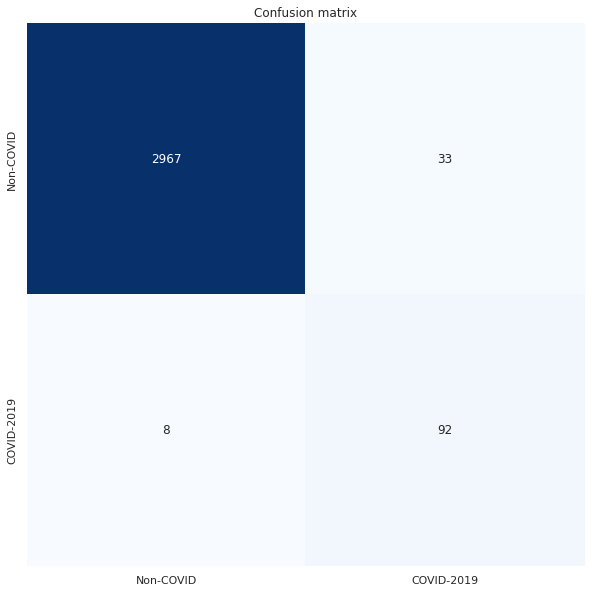

In [ ]:
# Plot normalized confusion matrix
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])

sn.set(rc={'figure.figsize':(10,10)})
ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Non-COVID','COVID-2019'], yticklabels= ['Non-COVID','COVID-2019'])
ax.set_title("Confusion matrix")
plt.savefig('./confusion_matrix_densenet121.png') #dpi = 200

## predicted prob distribution

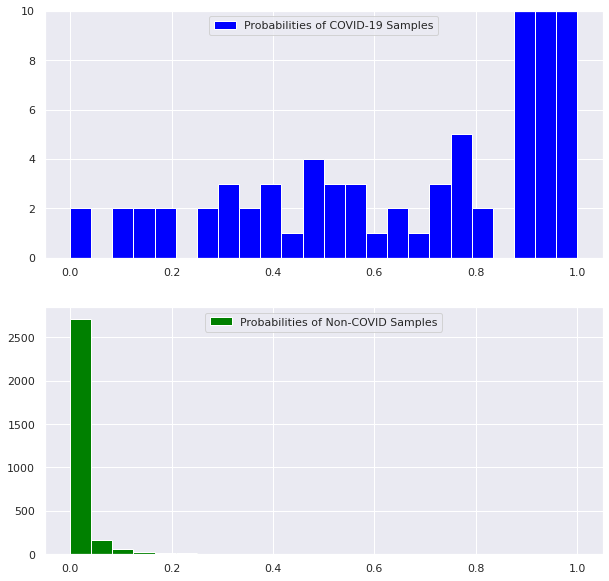

In [ ]:
############### plot the predicted probability distribution
bins = np.linspace(0, 1, 25)
plt.subplot(211)
plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
plt.ylim([0,10])
plt.legend(loc='upper center')
plt.subplot(212)
plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
plt.legend(loc='upper center')
plt.savefig('./scores_histogram_densenet121.png') #dpi = 200

## ROC Curve and AUC


Total Time: 0.36618852615356445


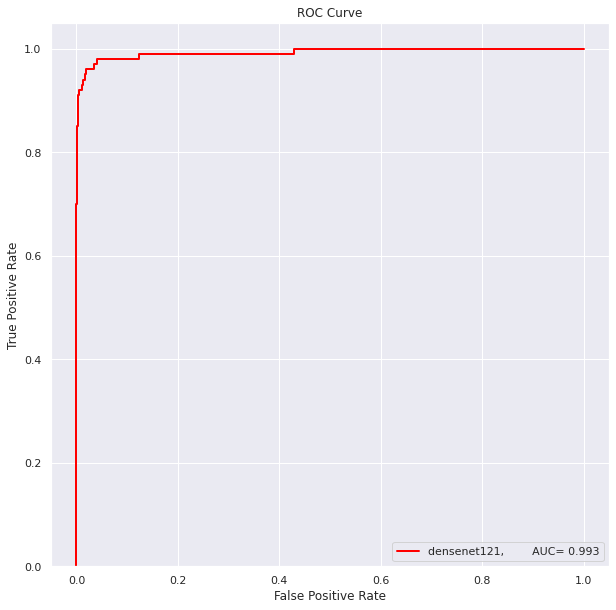

In [ ]:
############### ROC Curve and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

start_time= time.time()

y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
y_pred_res18= [covid_prob[i] for i in range(len(covid_prob))]+[non_prob[i] for i in range(len(non_prob))]

           
auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

plt.figure()
pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='red', linewidth=2,   label='densenet121,        AUC= %.3f' %auc_res18)
pyplot.ylim([0,1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title("ROC Curve")
# show the legend
pyplot.legend(loc='lower right')
plt.savefig('./ROC_covid19_densenet121.png') #dpi = 200



end_time= time.time()
tot_time= end_time- start_time
print("\nTotal Time:", tot_time)

# Load Model

In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project


In [ ]:
!ls

confusion_matrix_densenet121.png  ROC_covid19_densenet121.png
data_upload_v3			  saved_models
DONE-FOR-FINAL			  scores_histogram_densenet121.png
ishra_dataset			  Untitled
puran_files


In [ ]:
model_path = '/content/gdrive/MyDrive/Colab Notebooks/aust_academia/soft-comp-project/saved_models/3.densenet_121/covid_densenet121_epoch_63.pt'

model = torch.load(model_path)

In [ ]:
model

In [ ]:
print(len(dataloaders['train']))
print(len(dataloaders['test']))

121
155


# Visualize

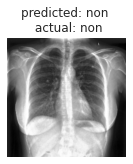

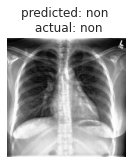

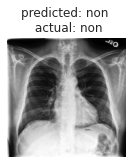

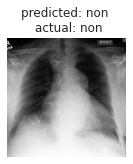

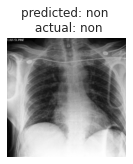

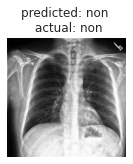

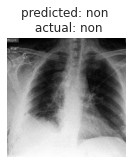

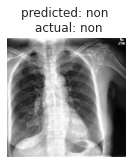

In [ ]:
visualize_model(model)